The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 梯度下降
:label:`sec_gd`

尽管*梯度下降*（gradient descent）很少直接用于深度学习，
但了解它是理解下一节随机梯度下降算法的关键。
例如，由于学习率过大，优化问题可能会发散，这种现象早已在梯度下降中出现。
同样地，*预处理*（preconditioning）是梯度下降中的一种常用技术，
还被沿用到更高级的算法中。
让我们从简单的一维梯度下降开始。

## 一维梯度下降

为什么梯度下降算法可以优化目标函数？
一维中的梯度下降给我们很好的启发。
考虑一类连续可微实值函数$f: \mathbb{R} \rightarrow \mathbb{R}$，
利用泰勒展开，我们可以得到

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

即在一阶近似中，$f(x+\epsilon)$可通过$x$处的函数值$f(x)$和一阶导数$f'(x)$得出。
我们可以假设在负梯度方向上移动的$\epsilon$会减少$f$。
为了简单起见，我们选择固定步长$\eta > 0$，然后取$\epsilon = -\eta f'(x)$。
将其代入泰勒展开式我们可以得到

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$
:eqlabel:`gd-taylor-2`

如果其导数$f'(x) \neq 0$没有消失，我们就能继续展开，这是因为$\eta f'^2(x)>0$。
此外，我们总是可以令$\eta$小到足以使高阶项变得不相关。
因此，

$$f(x - \eta f'(x)) \lessapprox f(x).$$

这意味着，如果我们使用

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会下降。
因此，在梯度下降中，我们首先选择初始值$x$和常数$\eta > 0$，
然后使用它们连续迭代$x$，直到停止条件达成。
例如，当梯度$|f'(x)|$的幅度足够小或迭代次数达到某个值时。

下面我们来展示如何实现梯度下降。为了简单起见，我们选用目标函数$f(x)=x^2$。
尽管我们知道$x=0$时$f(x)$能取得最小值，
但我们仍然使用这个简单的函数来观察$x$的变化。


In [1]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
def f(x):  # 目标函数
    return x ** 2

def f_grad(x):  # 目标函数的梯度(导数)
    return 2 * x

接下来，我们使用$x=10$作为初始值，并假设$\eta=0.2$。
使用梯度下降法迭代$x$共10次，我们可以看到，$x$的值最终将接近最优解。


In [3]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进行$x$优化的过程可以绘制如下。


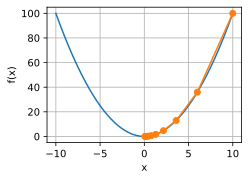

In [4]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### 学习率
:label:`subsec_gd-learningrate`

*学习率*（learning rate）决定目标函数能否收敛到局部最小值，以及何时收敛到最小值。
学习率$\eta$可由算法设计者设置。
请注意，如果我们使用的学习率太小，将导致$x$的更新非常缓慢，需要更多的迭代。
例如，考虑同一优化问题中$\eta = 0.05$的进度。
如下所示，尽管经过了10个步骤，我们仍然离最优解很远。


epoch 10, x: 3.486784


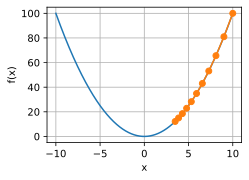

In [5]:
show_trace(gd(0.05, f_grad), f)

相反，如果我们使用过高的学习率，$\left|\eta f'(x)\right|$对于一阶泰勒展开式可能太大。
也就是说， :eqref:`gd-taylor`中的$\mathcal{O}(\eta^2 f'^2(x))$可能变得显著了。
在这种情况下，$x$的迭代不能保证降低$f(x)$的值。
例如，当学习率为$\eta=1.1$时，$x$超出了最优解$x=0$并逐渐发散。


epoch 10, x: 61.917364


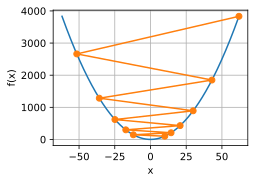

In [6]:
show_trace(gd(1.1, f_grad), f)

### 局部最小值

为了演示非凸函数的梯度下降，考虑函数$f(x) = x \cdot \cos(cx)$，其中$c$为某常数。
这个函数有无穷多个局部最小值。
根据我们选择的学习率，我们最终可能只会得到许多解的一个。
下面的例子说明了（不切实际的）高学习率如何导致较差的局部最小值。


epoch 10, x: -1.528166


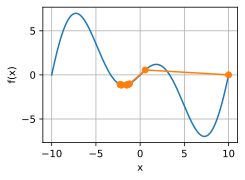

In [7]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

## 多元梯度下降

现在我们对单变量的情况有了更好的理解，让我们考虑一下$\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$的情况。
即目标函数$f: \mathbb{R}^d \to \mathbb{R}$将向量映射成标量。
相应地，它的梯度也是多元的：它是一个由$d$个偏导数组成的向量：

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

梯度中的每个偏导数元素$\partial f(\mathbf{x})/\partial x_i$代表了当输入$x_i$时$f$在$\mathbf{x}$处的变化率。
和先前单变量的情况一样，我们可以对多变量函数使用相应的泰勒近似来思考。
具体来说，

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

换句话说，在$\boldsymbol{\epsilon}$的二阶项中，
最陡下降的方向由负梯度$-\nabla f(\mathbf{x})$得出。
选择合适的学习率$\eta > 0$来生成典型的梯度下降算法：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

这个算法在实践中的表现如何呢？
我们构造一个目标函数$f(\mathbf{x})=x_1^2+2x_2^2$，
并有二维向量$\mathbf{x} = [x_1, x_2]^\top$作为输入，
标量作为输出。
梯度由$\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$给出。
我们将从初始位置$[-5, -2]$通过梯度下降观察$\mathbf{x}$的轨迹。

我们还需要两个辅助函数：
第一个是update函数，并将其应用于初始值20次；
第二个函数会显示$\mathbf{x}$的轨迹。


In [8]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

接下来，我们观察学习率$\eta = 0.1$时优化变量$\mathbf{x}$的轨迹。
可以看到，经过20步之后，$\mathbf{x}$的值接近其位于$[0, 0]$的最小值。
虽然进展相当顺利，但相当缓慢。


epoch 20, x1: -0.057646, x2: -0.000073


/home/d2l-worker/miniconda3/envs/d2l-zh-release-0/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


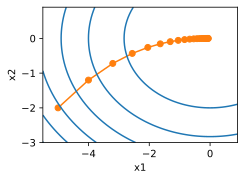

In [9]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 自适应方法

正如我们在 :numref:`subsec_gd-learningrate`中所看到的，选择“恰到好处”的学习率$\eta$是很棘手的。
如果我们把它选得太小，就没有什么进展；如果太大，得到的解就会振荡，甚至可能发散。
如果我们可以自动确定$\eta$，或者完全不必选择学习率，会怎么样？
除了考虑目标函数的值和梯度、还考虑它的曲率的二阶方法可以帮我们解决这个问题。
虽然由于计算代价的原因，这些方法不能直接应用于深度学习，但它们为如何设计高级优化算法提供了有用的思维直觉，这些算法可以模拟下面概述的算法的许多理想特性。

### 牛顿法

回顾一些函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，事实上我们可以把它写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

为了避免繁琐的符号，我们将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian，是$d \times d$矩阵。
当$d$的值很小且问题很简单时，$\mathbf{H}$很容易计算。
但是对于深度神经网络而言，考虑到$\mathbf{H}$可能非常大，
$\mathcal{O}(d^2)$个条目的存储代价会很高，
此外通过反向传播进行计算可能雪上加霜。
然而，我们姑且先忽略这些考量，看看会得到什么算法。

毕竟，$f$的最小值满足$\nabla f = 0$。
遵循 :numref:`sec_calculus`中的微积分规则，
通过取$\boldsymbol{\epsilon}$对 :eqref:`gd-hot-taylor`的导数，
再忽略不重要的高阶项，我们便得到

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

也就是说，作为优化问题的一部分，我们需要将Hessian矩阵$\mathbf{H}$求逆。

举一个简单的例子，对于$f(x) = \frac{1}{2} x^2$，我们有$\nabla f(x) = x$和$\mathbf{H} = 1$。
因此，对于任何$x$，我们可以获得$\epsilon = -x$。
换言之，单单一步就足以完美地收敛，而无须任何调整。
我们在这里比较幸运：泰勒展开式是确切的，因为$f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$。

让我们看看其他问题。
给定一个凸双曲余弦函数$c$，其中$c$为某些常数，
我们可以看到经过几次迭代后，得到了$x=0$处的全局最小值。


epoch 10, x: tensor(0.)


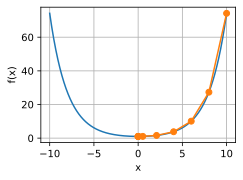

In [10]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

现在让我们考虑一个非凸函数，比如$f(x) = x \cos(c x)$，$c$为某些常数。
请注意在牛顿法中，我们最终将除以Hessian。
这意味着如果二阶导数是负的，$f$的值可能会趋于增加。
这是这个算法的致命缺陷！
让我们看看实践中会发生什么。


epoch 10, x: tensor(26.8341)


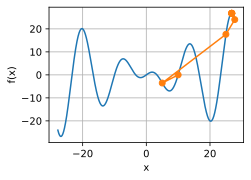

In [11]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？
一种方法是用取Hessian的绝对值来修正，另一个策略是重新引入学习率。
这似乎违背了初衷，但不完全是——拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。
让我们看看在学习率稍小的情况下它是如何生效的，比如$\eta = 0.5$。
如我们所见，我们有了一个相当高效的算法。


epoch 10, x: tensor(7.2699)


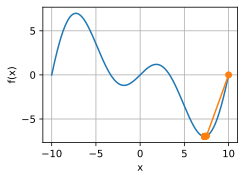

In [12]:
show_trace(newton(0.5), f)

### 收敛性分析

在此，我们以部分目标凸函数$f$为例，分析它们的牛顿法收敛速度。
这些目标凸函数三次可微，而且二阶导数不为零，即$f'' > 0$。
由于多变量情况下的证明是对以下一维参数情况证明的直接拓展，对我们理解这个问题不能提供更多帮助，因此我们省略了多变量情况的证明。

用$x^{(k)}$表示$x$在第$k^\mathrm{th}$次迭代时的值，
令$e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$表示$k^\mathrm{th}$迭代时与最优性的距离。
通过泰勒展开，我们得到条件$f'(x^*) = 0$可以写成

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),$$

这对某些$\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$成立。
将上述展开除以$f''(x^{(k)})$得到

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.$$

回想之前的方程$x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$。
代入这个更新方程，取两边的绝对值，我们得到

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.$$

因此，每当我们处于有界区域$\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$，
我们就有一个二次递减误差

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$$

另一方面，优化研究人员称之为“线性”收敛，而将$\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$这样的条件称为“恒定”收敛速度。
请注意，我们无法估计整体收敛的速度，但是一旦我们接近极小值，收敛将变得非常快。
另外，这种分析要求$f$在高阶导数上表现良好，即确保$f$在如何变化它的值方面没有任何“超常”的特性。

### 预处理

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。
它回避了计算整个Hessian，而只计算“对角线”项，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$

虽然这不如完整的牛顿法精确，但它仍然比不使用要好得多。
为什么预处理有效呢？
假设一个变量以毫米表示高度，另一个变量以公里表示高度的情况。
假设这两种自然尺度都以米为单位，那么我们的参数化就出现了严重的不匹配。
幸运的是，使用预处理可以消除这种情况。
梯度下降的有效预处理相当于为每个变量选择不同的学习率（矢量$\mathbf{x}$的坐标）。
我们将在后面一节看到，预处理推动了随机梯度下降优化算法的一些创新。

### 梯度下降和线搜索

梯度下降的一个关键问题是我们可能会超过目标或进展不足，
解决这一问题的简单方法是结合使用线搜索和梯度下降。
也就是说，我们使用$\nabla f(\mathbf{x})$给出的方向，
然后进行二分搜索，以确定哪个学习率$\eta$使$f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$取最小值。

有关分析和证明，此算法收敛迅速（请参见 :cite:`Boyd.Vandenberghe.2004`）。
然而，对深度学习而言，这不太可行。
因为线搜索的每一步都需要评估整个数据集上的目标函数，实现它的方式太昂贵了。

## 小结

* 学习率的大小很重要：学习率太大会使模型发散，学习率太小会没有进展。
* 梯度下降会可能陷入局部极小值，而得不到全局最小值。
* 在高维模型中，调整学习率是很复杂的。
* 预处理有助于调节比例。
* 牛顿法在凸问题中一旦开始正常工作，速度就会快得多。
* 对于非凸问题，不要不作任何调整就使用牛顿法。

## 练习

1. 用不同的学习率和目标函数进行梯度下降实验。
1. 在区间$[a, b]$中实现线搜索以最小化凸函数。
    1. 你是否需要导数来进行二分搜索，即决定选择$[a, (a+b)/2]$还是$[(a+b)/2, b]$。
    1. 算法的收敛速度有多快？
    1. 实现该算法，并将其应用于求$\log (\exp(x) + \exp(-2x -3))$的最小值。
1. 设计一个定义在$\mathbb{R}^2$上的目标函数，它的梯度下降非常缓慢。提示：不同坐标的缩放方式不同。
1. 使用预处理实现牛顿方法的轻量级版本：
    1. 使用对角Hessian作为预条件。
    1. 使用它的绝对值，而不是实际值（可能有符号）。
    1. 将此应用于上述问题。
1. 将上述算法应用于多个目标函数（凸或非凸）。如果你把坐标旋转$45$度会怎么样？


[Discussions](https://discuss.d2l.ai/t/3836)
